In [4]:
from pycbc.waveform import td_approximants,fd_approximants
print("pycbc中可用的时间域TD:",td_approximants())
print("-------------------")
print("pycbc中可用的频率域FD",fd_approximants())

pycbc中可用的时间域TD: ['TaylorT1', 'TaylorT2', 'TaylorT3', 'SpinTaylorT1', 'SpinTaylorT4', 'SpinTaylorT5', 'PhenSpinTaylor', 'PhenSpinTaylorRD', 'EOBNRv2', 'EOBNRv2HM', 'TEOBResum_ROM', 'SEOBNRv1', 'SEOBNRv2', 'SEOBNRv2_opt', 'SEOBNRv3', 'SEOBNRv3_pert', 'SEOBNRv3_opt', 'SEOBNRv3_opt_rk4', 'SEOBNRv4', 'SEOBNRv4_opt', 'SEOBNRv4P', 'SEOBNRv4PHM', 'SEOBNRv2T', 'SEOBNRv4T', 'SEOBNRv4_ROM_NRTidalv2', 'SEOBNRv4_ROM_NRTidalv2_NSBH', 'HGimri', 'IMRPhenomA', 'IMRPhenomB', 'IMRPhenomC', 'IMRPhenomD', 'IMRPhenomD_NRTidalv2', 'IMRPhenomNSBH', 'IMRPhenomHM', 'IMRPhenomPv2', 'IMRPhenomPv2_NRTidal', 'IMRPhenomPv2_NRTidalv2', 'TaylorEt', 'TaylorT4', 'EccentricTD', 'SpinDominatedWf', 'NR_hdf5', 'NRSur7dq2', 'NRSur7dq4', 'SEOBNRv4HM', 'NRHybSur3dq8', 'IMRPhenomXAS', 'IMRPhenomXHM', 'IMRPhenomPv3', 'IMRPhenomPv3HM', 'IMRPhenomXP', 'IMRPhenomXPHM', 'TEOBResumS', 'IMRPhenomT', 'IMRPhenomTHM', 'IMRPhenomTP', 'IMRPhenomTPHM', 'SEOBNRv4HM_PA', 'pSEOBNRv4HM_PA', 'IMRPhenomXAS_NRTidalv2', 'IMRPhenomXP_NRTidalv2', 'IM

/home/ywq/anaconda3/envs/PSOlinux/lib/python3.12/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


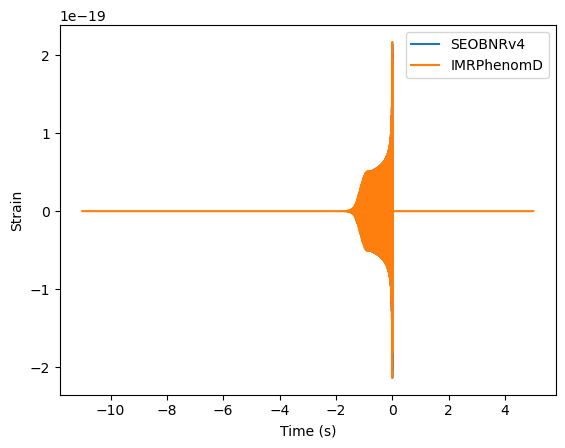

In [1]:
import matplotlib.pyplot as pp
from pycbc.waveform import get_td_waveform

# SEOBMRv4和IMRPhenomD分别是两种近似模型
for apx in ['SEOBNRv4', 'IMRPhenomD']:
    hp, hc = get_td_waveform(approximant=apx,
                                 mass1=10, # 第一个天体质量
                                 mass2=10, # 第二个天体质量
                                 spin1z=0.9, # 天体自选参数
                                 delta_t=1.0/4096, # 时间间隔
                                 f_lower=40) # 最低频率
# hp.sample_times是时间
    pp.plot(hp.sample_times, hp, label=apx)

pp.ylabel('Strain')
pp.xlabel('Time (s)')
pp.legend()
pp.show()

The match is: 0.9534


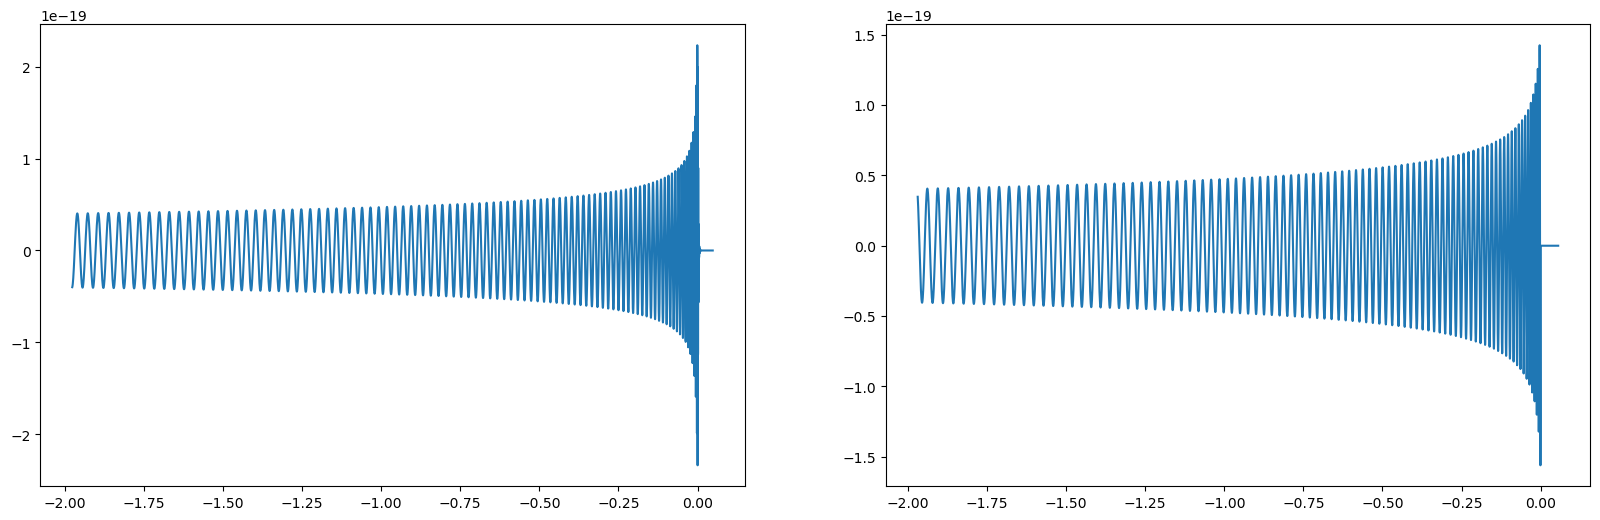

In [2]:
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from matplotlib import pyplot as plt

f_low = 30
sample_rate = 4096

# Generate the two waveforms to compare
hp, hc = get_td_waveform(approximant="EOBNRv2",
                         mass1=10,
                         mass2=10,
                         f_lower=f_low,
                         delta_t=1.0/sample_rate)

sp, sc = get_td_waveform(approximant="TaylorT4",
                         mass1=10,
                         mass2=10,
                         f_lower=f_low,
                         delta_t=1.0/sample_rate)

# Resize the waveforms to the same length
tlen = max(len(sp), len(hp))
sp.resize(tlen)
hp.resize(tlen)

# Generate the aLIGO ZDHP PSD
delta_f = 1.0 / sp.duration
flen = tlen//2 + 1
psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

# Note: This takes a while the first time as an FFT plan is generated
# subsequent calls are much faster.
m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low)
print('The match is: {:.4f}'.format(m))

plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.plot(hp.sample_times, hp, label='EOBNRv2')
plt.subplot(1, 2, 2)
plt.plot(sp.sample_times, sp, label='TaylorT4')
plt.show()

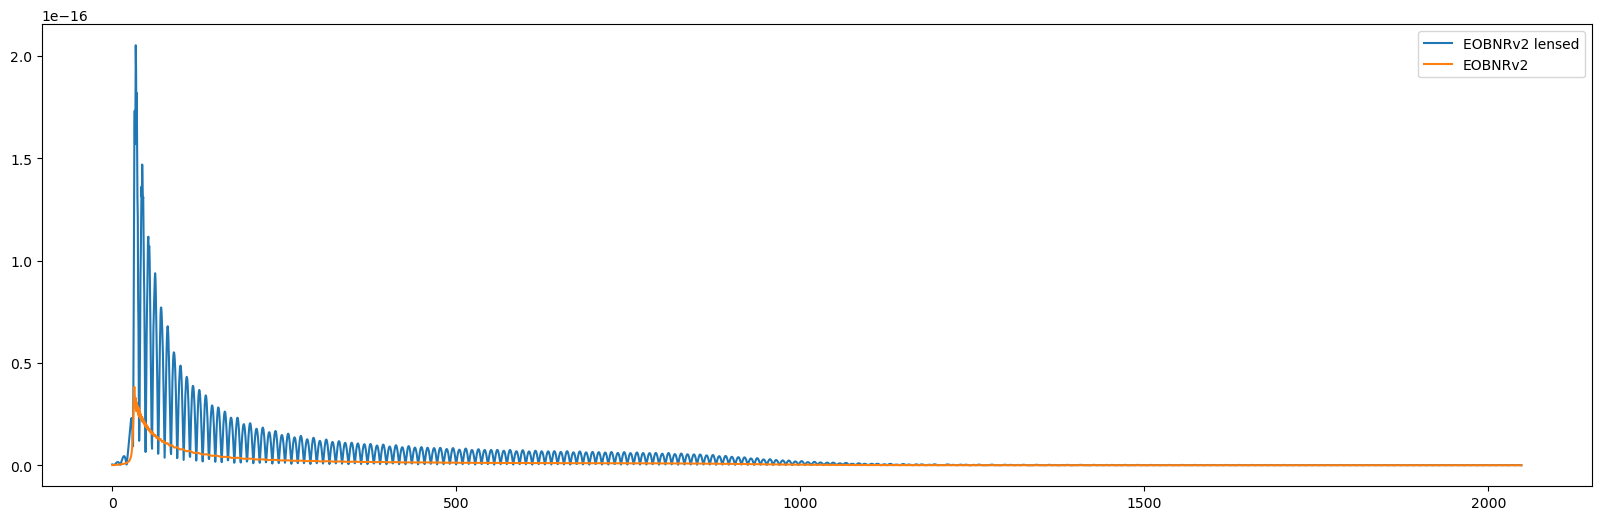

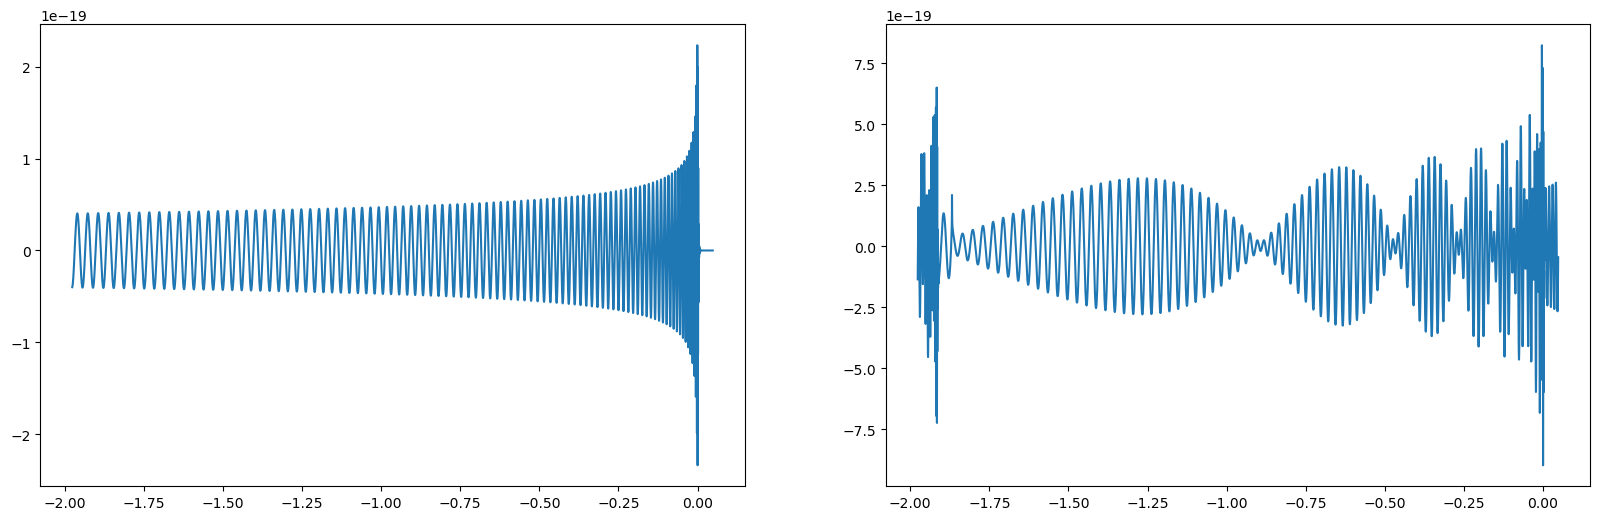

In [3]:
import numpy as np
G = 6.67430e-11  # 万有引力常数, m^3 kg^-1 s^-2
c = 2.998e8  # 光速, m/s
M_sun = 1.989e30  # 太阳质量, kg
pc = 3.086e16  # pc到m的转换
hp_f = np.fft.rfft(hp)
freqs = np.fft.rfftfreq(len(hp), d=hp.delta_t)

Mlz = 1e6 * M_sun
omega = 2 * np.pi * freqs
w = G * 4 *Mlz * omega / c**3
y = 0.1

# 定义光学极限的透镜化
def generate_f_geo(w,y):
    F_geo = np.sqrt(1 + 1/y) - 1j * np.sqrt(-1 + 1 / y) * np.exp(1j * w * 2 * y)
    return F_geo
# 生成透镜化，频域
F_geo = generate_f_geo(w,y)

# h_lens = h * F_geo
# 将信号透镜化 （频域）
lens_f = hp_f * F_geo
# 逆傅里叶变换将频域信号转换为时域信号
h_lens = np.fft.irfft(lens_f) 

plt.figure(figsize=(20,6))
plt.plot(freqs, np.abs(lens_f), label='EOBNRv2 lensed')
plt.plot(freqs, np.abs(hp_f), label='EOBNRv2')
plt.legend()
plt.show()

plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.plot(hp.sample_times, hp, label='EOBNRv2')
plt.subplot(1, 2, 2)
plt.plot(hp.sample_times, h_lens, label='EOBNRv2 lensed')
plt.show()